In [ ]:
%tensorflow_version 2.x
%load_ext tensorboard
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install mne

     |████████████████████████████████| 7.0MB 6.5MB/s 


In [ ]:
!pip install -U tensorboard-plugin-profile

Requirement already up-to-date: tensorboard-plugin-profile in /usr/local/lib/python3.7/dist-packages (2.4.0)


In [ ]:
from mne.datasets.sleep_physionet.age import fetch_data

from tensorflow.keras.layers import (
  Input, BatchNormalization, Flatten, Dense, LeakyReLU, Dropout, Activation, Concatenate, Add,
  Conv2D, MaxPooling2D, GlobalAveragePooling2D,
  Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, Multiply
)
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import mne
import numpy as np
import csv
import os
import cv2
import datetime

In [ ]:
def build_dataset(no_of_people=20):
  dataset = {'x': [], 'y':[]}
  people = [i for i in range(no_of_people)]
  sf = 100
  annotation_desc_2_event_id = {'Sleep stage W': 1,
                                'Sleep stage 1': 2,
                                'Sleep stage 2': 3,
                                'Sleep stage 3': 4,
                                'Sleep stage 4': 4,
                                'Sleep stage R': 5}
  event_id = {'Sleep stage W': 1,
              'Sleep stage 1': 2,
              'Sleep stage 2': 3,
              'Sleep stage 3/4': 4,
              'Sleep stage R': 5}
  
  tmax = 30. - 1. / sf
  
  files = fetch_data(subjects=people, recording=[1])
  
  count = 0
  for file in files:
      raw = mne.io.read_raw_edf(file[0])
      annot = mne.read_annotations(file[1])
      raw.set_annotations(annot, emit_warning=False)
      events, _ = mne.events_from_annotations(
          raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
      epochs = mne.Epochs(raw=raw, events=events,
                                event_id=event_id, tmin=0., tmax=tmax, baseline=None)
      
      if count == 0:
          X = (epochs.get_data(picks="eeg"))[:,0,:]
          Y = epochs.events[:, 2]
          count += 1
      else:
          x = (epochs.get_data(picks="eeg"))[:,0,:]
          y = epochs.events[:, 2]
          X = np.concatenate((X, x), axis=0)
          Y = np.concatenate((Y, y), axis=0)
      
  #X = (epochs_test.get_data(picks="eeg"))[:,0,:]
  #Y = epochs_test.events[:, 2]
  dataset['x1'] = X
  dataset['y'] = Y
  return dataset

In [ ]:
def normalize_vector(vector):
  normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
  return normalized_vector

In [ ]:
dataset = build_dataset(10)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data



Verifying hash adabd3b01fc7bb75c523a974f38ee3ae4e57b40f.



Verifying hash 21c998eadc8b1e3ea6727d3585186b8f76e7e70b.



Verifying hash 4d17451f7847355bcab17584de05e7e1df58c660.



Verifying hash d582a3cbe2db481a362af890bc5a2f5ca7c878dc.



Verifying hash 8b135afa7fb93bb5f1998fda50355944777c245e.



Verifying hash 91043cfe46695088b17b6a02937b25efd674c3fb.



Verifying hash 85e58dc1e3303537dade8c5827ab58328239c384.



Verifying hash 6363d8b0fdc48cf396c9abf054bb4a9696d38bdb.



Verifying hash 04d2b88d25f2ae4a65ba44cd9145bd12800a0e20.



Verifying hash f148821669bd3588187b3b430bd79adf569f86d1.



Verifying hash ea073451b65ce8a6f1a02a8cc2b89d1a162ca0ae.



Verifying hash 4159ef8a3e119d6dcc1bede806f6fbc017b27a0f.



Verifying hash 1736736e585807c14f1ae8bc87a94cae222c5170.



Verifying hash 4bf99622c67c281b25ceccd35e7050328a2946e8.



Verifying hash 1374b34f6139b6ff7e865d8243eef39ba334ef50.



Verifying hash 608024fd19a140ad233a4680e07c2495a74b69c2.



Verifying hash 0e1cc2c4e1da14ab94515e3e7e75e8ad30ec99cb.



Verifying hash 9ec663ffa5c17afcaca59d7829d77b9165102237.



Verifying hash b3502e0bd54683e973182c791aa962b804e79633.



Verifying hash 7aa63b408c769a4a983a908b6ba41d87dd743c6e.
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
2650 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2650 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
2802 matching events found
No baseline correction applied
0 projection items ac

In [ ]:
dataset["x1"].shape

(27464, 3000)

In [ ]:
x_train = np.array([normalize_vector(i) for i in dataset['x1']], dtype=np.float)
print(x_train.shape, x_train.dtype, x_train.max(), x_train.min())

(27464, 3000) float64 1.0 0.0


In [ ]:
#1 1
#2 1021
#3 1025
#4 1038
#5 1199
np.where(dataset["y"] == 5)

(array([ 1199,  1200,  1201, ..., 26509, 26510, 26511]),)

In [ ]:
plt.style.use('/content/fig.mplstyle')
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator

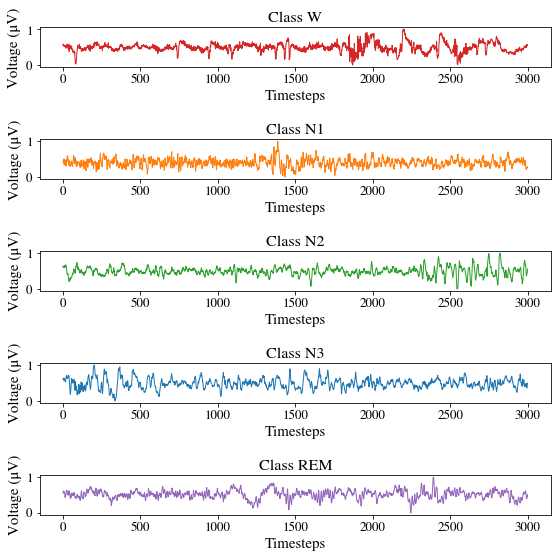

In [ ]:
fig, axs = plt.subplots(5, figsize=[8, 8])

#1 1
#2 1021
#3 1025
#4 1038
#5 1199

axs[0].plot(x_train[1], alpha=1, color="tab:red", linestyle = '-', lw=1,)
axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('Voltage (μV)')
axs[0].set_title("Class W")

axs[1].plot(x_train[1021], alpha=1, color="tab:orange", linestyle = '-', lw=1,)
axs[1].set_xlabel('Timesteps')
axs[1].set_ylabel('Voltage (μV)')
axs[1].set_title("Class N1")

axs[2].plot(x_train[1025], alpha=1, color="tab:green", linestyle = '-', lw=1,)
axs[2].set_xlabel('Timesteps')
axs[2].set_ylabel('Voltage (μV)')
axs[2].set_title("Class N2")

axs[3].plot(x_train[1038], alpha=1, color="tab:blue", linestyle = '-', lw=1,)
axs[3].set_xlabel('Timesteps')
axs[3].set_ylabel('Voltage (μV)')
axs[3].set_title("Class N3")

axs[4].plot(x_train[1199], alpha=1, color="tab:purple", linestyle = '-', lw=1,)
axs[4].set_xlabel('Timesteps')
axs[4].set_ylabel('Voltage (μV)')
axs[4].set_title("Class REM")

axs[0].yaxis.set_major_formatter(ScalarFormatter())
axs[0].yaxis.major.formatter._useMathText = True

# plt.xticks(np.arange(1,26, 4))

plt.tight_layout()
plt.savefig('/content/intro.png', dpi=300, transparent=False, bbox="tight")
plt.show()

In [ ]:
def get_spectrogram(data, fs, nfft, noverlap, cmap):
  fig, ax = plt.subplots()
  pxx, freqs, bins, im = ax.specgram(x=data, Fs=fs, noverlap=noverlap, NFFT=nfft, cmap=cmap)

  plt.ylabel('Frequency (Hz)')
  plt.xlabel('Time (s)')
  plt.colorbar(im)

  ax.yaxis.set_major_formatter(ScalarFormatter())
  ax.yaxis.major.formatter._useMathText = True
  # ax.axis('off')
  ax.grid(False)

  plt.savefig('/content/spectrogram.png', dpi=300, transparent=False, bbox="tight")
  plt.show()

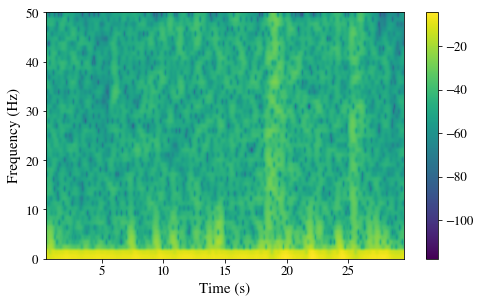

In [ ]:
x = normalize_vector(x_train[1,:])

spec = get_spectrogram(x, 100, 100, 99, "viridis")

In [ ]:
!git clone https://gitlab.com/parag1999/sleepdataset.git

Cloning into 'sleepdataset'...
remote: Enumerating objects: 54597, done.
remote: Counting objects: 100% (54597/54597), done.
remote: Compressing objects: 100% (54597/54597), done.
remote: Total 54597 (delta 0), reused 54597 (delta 0), pack-reused 0
Receiving objects: 100% (54597/54597), 257.11 MiB | 34.32 MiB/s, done.
Checking out files: 100% (54587/54587), done.


In [ ]:
os.chdir('./sleepdataset')

In [ ]:
X = np.zeros((27464, 36, 54, 3))
for images in range(27464):
  spectrogram  = cv2.imread(os.getcwd()+"/"+str(images)+".png")
  normgram = normalize_vector(spectrogram)
  if normgram.shape == (288,432,3):
    new_image = cv2.resize(spectrogram, (54, 36))
    cv2.imwrite(os.getcwd()+"/"+str(images)+".png", new_image)
    normgram = new_image
  X[images,:,:,:] = normgram

dataset["x2"] = X

In [ ]:
print(dataset['x1'].shape, dataset['x1'].dtype)
print(dataset['x2'].shape, dataset['x2'].dtype)
print(dataset['y'].shape, dataset['y'].dtype)

(27464, 3000) float64
(27464, 36, 54, 3) float64
(27464,) int64


In [ ]:
def preprocess_dataset(dataset, test_size=0.1, val_size=0.2):
  x_1d = np.array([normalize_vector(i) for i in dataset['x1']], dtype=np.float)
  x_1d = np.reshape(x_1d, (x_1d.shape[0], x_1d.shape[1], 1))
  y = np.array(dataset['y'], dtype=np.uint8)
  x_2d = dataset["x2"]
  ohe = OneHotEncoder()
  y = ohe.fit_transform(y.reshape((-1,1))).toarray()
  
  x_1d_train, x_1d_test, x_2d_train, x_2d_test, y_train, y_test = train_test_split(x_1d, x_2d, y, test_size=test_size, random_state=42, shuffle=True)
  x_1d_train, x_1d_val, x_2d_train, x_2d_val, y_train, y_val = train_test_split(x_1d_train, x_2d_train, y_train, test_size=val_size, random_state=42, shuffle=True)

  print(x_1d_train.shape, x_2d_train.shape, y_train.shape)
  print(x_1d_val.shape, x_2d_val.shape, y_val.shape)
  print(x_1d_test.shape, x_2d_test.shape, y_test.shape)
  
  return x_1d_train, x_1d_test, x_1d_val, x_2d_train, x_2d_test, x_2d_val, y_train, y_test, y_val

In [ ]:
x_1d_train, x_1d_test, x_1d_val, x_2d_train, x_2d_test, x_2d_val, y_train, y_test, y_val = preprocess_dataset(dataset, 0.15, 0.34)

(15407, 3000, 1) (15407, 36, 54, 3) (15407, 5)
(7937, 3000, 1) (7937, 36, 54, 3) (7937, 5)
(4120, 3000, 1) (4120, 36, 54, 3) (4120, 5)


In [ ]:
plt.style.use('/content/fig.mplstyle')

#1D CNN WAVENET

In [ ]:
# input_shape = (3000, )
output_shape = 128
kernel_size = 2
dilation_depth = 8
n_filters = 40
    
    
def residual_block(n_filters, kernel_size, x, i):
  tanh_out = Conv1D(n_filters, 
                    kernel_size = kernel_size, 
                    dilation_rate = kernel_size**i, 
                    padding='causal', 
                    name='dilated_conv_%d_tanh' % (kernel_size ** i), 
                    activation='tanh'
                    )(x)
  sigm_out = Conv1D(n_filters, 
                    kernel_size  = kernel_size, 
                    dilation_rate = kernel_size**i, 
                    padding='causal', 
                    name='dilated_conv_%d_sigm' % (kernel_size ** i), 
                    activation='sigmoid'
                    )(x)
  z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
  skip = Conv1D(n_filters, 1, name='skip_%d'%(i))(z)
  res = Add(name='residual_block_%d' % (i))([skip, x])
  return res, skip

def build_1d_cnn_wavenet(cnn_input):    
  # x = Input(shape=input_shape, name='original_input')
  skip_connections = []
  out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(cnn_input)
  
  for i in range(1, dilation_depth + 1):
    out, skip = residual_block(n_filters, kernel_size, out,i)
    skip_connections.append(skip)
    
  out = Add(name='skip_connections')(skip_connections)
  out = Activation('relu')(out)
  out = Conv1D(n_filters, 80, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(out)
  out = AveragePooling1D(80, padding='same', name='downsample_to_200Hz')(out)
  out = Conv1D(n_filters, 100, padding='same', activation='relu', name='conv_500ms')(out)
  out = Conv1D(output_shape, 100, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
  out = AveragePooling1D(100, padding='same',name = 'downsample_to_2Hz')(out)
  
  out = Conv1D(output_shape, (1), padding='same', name='final_conv')(out)
  out = GlobalAveragePooling1D( name='final_pooling')(out)
  out = Flatten()(out)

  model = Model(cnn_input, out)  
  return model


# 2D CNN

In [ ]:
def build_2d_cnn(cnn_input=None):
  x = Conv2D(16, (3, 3), padding='same', kernel_regularizer=l1_l2(1e-3))(cnn_input)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l1_l2(1e-3))(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l1_l2(1e-3))(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l1_l2(1e-3))(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l1_l2(1e-3))(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l1_l2(1e-3))(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  
  model = Model(inputs=cnn_input, outputs=x)
  return model

# Ensemble

In [ ]:
def load_model_1d_wavenet():
  model_1d = load_model('/content/model_1dconv_wavenet_e15-bs16-a93.37-va93.13.h5')
  for layer in model_1d.layers:
    layer._name = layer.name + str("_1w")
  model_1d_new = Model(model_1d.input, model_1d.layers[-4].output)
  model_1d_new.trainable = False
  return model_1d_new

In [ ]:
def load_model_2d():
  model_2d = load_model('/content/model_2dconv_e15-bs16-a93.85-va93.09.h5')
  for layer in model_2d.layers:
    layer._name = layer.name + str("_2")
  model_2d_new = Model(model_2d.input, model_2d.layers[-3].output)
  model_2d_new.trainable = False
  return model_2d_new

In [ ]:
def build_model(height, width, depth, time_steps, features, classes):
  input_1d = Input(shape=(time_steps, features))
  input_2d = Input(shape=(height, width, depth))

  # model_1d_w = build_1d_cnn_wavenet(input_1d)
  model_1d_w = load_model_1d_wavenet()

  # model_2d = build_2d_cnn(input_2d)
  model_2d = load_model_2d()

  combined = Concatenate()([model_1d_w.output, model_2d.output])

  x = Dropout(0.5)(combined)
  x = Dense(32)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Dropout(0.5)(x)
  x = Dense(classes, activation='softmax')(x)

  model = Model(inputs=[model_1d_w.input, model_2d.input], outputs=x)
  return model

In [ ]:
a, b, c, d = [], [], [], []

In [ ]:
model = build_model(36, 54, 3, 3000, 1, 5)
# model.summary()

In [ ]:
# from tensorflow.keras.models import load_model
# plot_model(model, to_file='../model.png', show_shapes=True, show_layer_names=True)

In [ ]:
import datetime

INIT_LR = 0.0003
EPOCHS = 15
BATCH_SIZE = 16

def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0

  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, profile_batch = '500,520')

callbacks = [LearningRateScheduler(poly_decay), tensorboard_callback]

In [ ]:
opt = Adam(lr=INIT_LR, amsgrad=True, beta_1=0.5)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [ ]:
r = model.fit(
  [x_1d_train, x_2d_train], y_train,
  validation_data=([x_1d_val, x_2d_val], y_val),
  epochs=EPOCHS, batch_size=BATCH_SIZE,
  callbacks=callbacks
)

Epoch 1/15
1914/1914 [==============================] - 51s 25ms/step - loss: 1.1751 - accuracy: 0.6647 - val_loss: 0.4239 - val_accuracy: 0.9391
Epoch 2/15
1914/1914 [==============================] - 44s 23ms/step - loss: 0.4902 - accuracy: 0.9156 - val_loss: 0.4153 - val_accuracy: 0.9403
Epoch 3/15
1914/1914 [==============================] - 44s 23ms/step - loss: 0.4610 - accuracy: 0.9221 - val_loss: 0.4072 - val_accuracy: 0.9416
Epoch 4/15
1914/1914 [==============================] - 45s 23ms/step - loss: 0.4503 - accuracy: 0.9264 - val_loss: 0.4097 - val_accuracy: 0.9430
Epoch 5/15
1914/1914 [==============================] - 45s 23ms/step - loss: 0.4452 - accuracy: 0.9260 - val_loss: 0.4066 - val_accuracy: 0.9428
Epoch 6/15
1914/1914 [==============================] - 44s 23ms/step - loss: 0.4367 - accuracy: 0.9264 - val_loss: 0.4006 - val_accuracy: 0.9424
Epoch 7/15
1914/1914 [==============================] - 44s 23ms/step - loss: 0.4306 - accuracy: 0.9295 - val_loss: 0.4036 -

In [ ]:
# %tensorboard --logdir=logs

In [ ]:
a += r.history['loss']
b += r.history['val_loss']
c += r.history['accuracy']
d += r.history['val_accuracy']

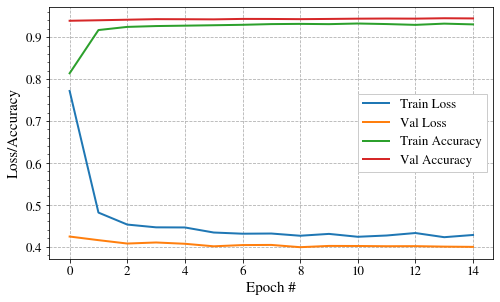

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator
import matplotlib as mpl
import json
plt.style.use('/content/PaperDoubleFig.mplstyle')

fig, ax = plt.subplots()

# plt.xticks(np.arange(0,EPOCHS, 2))

ax.plot(a, linestyle = '-', lw=2, label="Train Loss", alpha=1)
ax.plot(b, linestyle = '-', lw=2, label="Val Loss", alpha=1)
ax.plot(c, linestyle = '-', lw=2, label="Train Accuracy", alpha=1)
ax.plot(d, linestyle = '-', lw=2, label="Val Accuracy", alpha=1)
# ax.plot(np.arange(1,EPOCHS+1), r.history['lr'], linestyle = '-', lw=2, label="Learning rate", alpha=1)

ax.set_xlabel('Epoch #')
ax.set_ylabel('Loss/Accuracy')

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
ax.yaxis.major.formatter._useMathText = True
ax.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('/content/spatialNet_training.pdf', dpi=300, transparent=False, bbox="tight")
plt.savefig('/content/spatialNet_training.png', dpi=300, transparent=False, bbox="tight")

plt.show()

In [ ]:
save_model(model, '../model_spatiotemporalnet_e{}-bs{}-a{:.2f}-va{:.2f}.h5'.format(EPOCHS, BATCH_SIZE, 100*r.history['accuracy'][-1], 100*r.history['val_accuracy'][-1]))
model.save_weights('../model_spatiotemporalnet_weights_e{}-bs{}-a{:.2f}-va{:.2f}.h5'.format(EPOCHS, BATCH_SIZE, 100*r.history['accuracy'][-1], 100*r.history['val_accuracy'][-1]))

# Result Analysis

In [ ]:
model.evaluate([x_1d_test, x_2d_test], y_test)

256/256 [==============================] - 7s 25ms/step - loss: 0.3688 - accuracy: 0.9442


[0.36880236864089966, 0.944193422794342]

In [ ]:
preds = model.predict([x_1d_test, x_2d_test]).argmax(axis=1)

In [ ]:
ohe = OneHotEncoder()
preds = ohe.fit_transform(preds.reshape((-1,1))).toarray()

In [ ]:
target_names = ['W', 'N1', 'N2', 'N3', 'REM']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

           W       0.99      0.99      0.99      5608
          N1       0.60      0.36      0.45       201
          N2       0.88      0.92      0.90      1381
          N3       0.90      0.86      0.88       433
         REM       0.79      0.83      0.81       566

   micro avg       0.94      0.94      0.94      8189
   macro avg       0.83      0.79      0.81      8189
weighted avg       0.94      0.94      0.94      8189
 samples avg       0.94      0.94      0.94      8189



In [ ]:
def plot_confusion_matrix_custom(cm, classes, normalize=False, title='Confusion matrix for SpatioTemporalNet', cmap='PuBuGn'):
  import itertools
  # plt.figure(figsize=[10,8])
  plt.grid(b=None)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  # plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('Ground Truth Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()
  plt.grid(False)
  plt.savefig('/content/spatialNet_cm.pdf', dpi=300, transparent=False, bbox="tight")
  plt.savefig('/content/spatialNet_cm.png', dpi=300, transparent=False, bbox="tight")
  plt.show()

Confusion matrix, without normalization
[[5555   15   17    1   20]
 [  39   73   39    0   50]
 [  10   16 1264   39   52]
 [   4    0   57  371    1]
 [  22   18   57    0  469]]


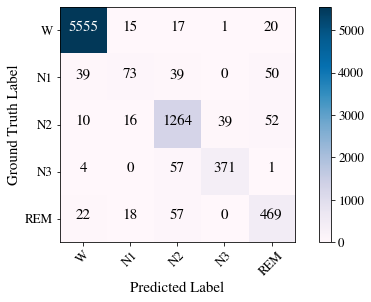

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

confusion_matrix_output = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
plot_confusion_matrix_custom(confusion_matrix_output, classes=['W', 'N1', 'N2', 'N3', 'REM'], cmap="PuBu")

# Inference Time Profiling

In [ ]:
def load_models():
  model_e = load_model('/content/model_1d-wavenet_2d-sequential_e15-bs16-a93.34-va94.49.h5')
  model_s = load_model('/content/model_2dconv_e15-bs16-a93.85-va93.09.h5')
  model_t = load_model('/content/model_1dconv_wavenet_e15-bs16-a93.37-va93.13.h5')
  return model_e, model_s, model_t

In [ ]:
model_e, model_s, model_t = load_models()

In [ ]:
import torch
dummy_input_1d = tf.random.uniform((1, 3000, 1), minval=0.0, maxval=1.0, dtype=tf.float64)
dummy_input_2d = tf.random.uniform((1, 36, 54, 3), minval=0.0, maxval=1.0, dtype=tf.float64)

actual_input_1d = x_1d_test[0:100]
actual_input_2d = x_2d_test[0:100]

repetitions = 300

In [ ]:
# SpatioTemporalNet
timings_stn = []
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

#GPU-WARM-UP
for _ in range(100):
  _ = model_e.predict([dummy_input_1d, dummy_input_2d])
print("warming up done")

# MEASURE PERFORMANCE
for rep in range(repetitions):
  starter.record()
  _ = model_e.predict([actual_input_1d, actual_input_2d])
  ender.record()
  # WAIT FOR GPU SYNC
  torch.cuda.synchronize()
  curr_time = starter.elapsed_time(ender)
  timings_stn.append(curr_time)

mean_syn = sum(timings_stn) / repetitions
print("Inference time mean: {:.4f}".format(mean_syn))

warming up done
Inference time mean: 150.9928


In [ ]:
# SpatialNet
timings_sn = []
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

#GPU-WARM-UP
for _ in range(100):
  _ = model_s.predict(dummy_input_2d)
print("warming up done")

# MEASURE PERFORMANCE
for rep in range(repetitions):
  starter.record()
  _ = model_s.predict(actual_input_2d)
  ender.record()
  # WAIT FOR GPU SYNC
  torch.cuda.synchronize()
  curr_time = starter.elapsed_time(ender)
  timings_sn.append(curr_time)

mean_syn = sum(timings_sn) / (repetitions)
print("Inference time mean: {:.4f}".format(mean_syn))

warming up done
Inference time mean: 38.0708


In [ ]:
# TemporalNet
timings_tn = []
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

#GPU-WARM-UP
for _ in range(100):
  _ = model_t.predict(dummy_input_1d)
print("warming up done")

# MEASURE PERFORMANCE
for rep in range(repetitions):
  starter.record()
  _ = model_t.predict(actual_input_1d)
  ender.record()
  # WAIT FOR GPU SYNC
  torch.cuda.synchronize()
  curr_time = starter.elapsed_time(ender)
  timings_tn.append(curr_time)

mean_syn = sum(timings_tn) / (repetitions)
print("Inference time mean: {:.4f}".format(mean_syn))

warming up done
Inference time mean: 142.0321


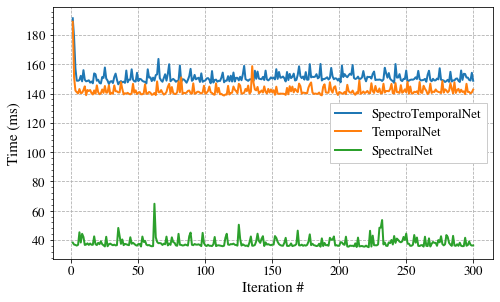

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator
import matplotlib as mpl
import json

fig1, ax1 = plt.subplots()

# plt.xticks(np.arange(1, 300, 30))

ax1.plot(np.arange(1, repetitions+1), timings_stn, linestyle = '-', lw=2, label="SpectroTemporalNet", alpha=1)
ax1.plot(np.arange(1, repetitions+1), timings_tn, linestyle = '-', lw=2, label="TemporalNet", alpha=1)
ax1.plot(np.arange(1, repetitions+1), timings_sn, linestyle = '-', lw=2, label="SpectralNet", alpha=1)

ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Time (ms)')

ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.major.formatter._useMathText = True
ax1.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('/content/timings1.pdf', dpi=300, transparent=False, bbox="tight")
plt.savefig('/content/timings1.png', dpi=300, transparent=False, bbox="tight")

plt.show()